## Monitoring Shopping Cart Recommendations

Note: Requires reclist (https://reclist.io/) to be installed. We ran the following code successfully with reclist version 0.3.1.

In [1]:
import os
import pickle
import collections
from scipy.spatial.distance import cosine
import numpy as np

from reclist.datasets import CoveoDataset
from reclist.recommenders.prod2vec import CoveoP2VRecModel
from reclist.reclist import CoveoCartRecList

import uptrain

In [2]:
coveo_dataset = CoveoDataset()

In [3]:
if not os.path.exists('model_shopping_cart.pickle'):
    model = CoveoP2VRecModel()
    model.train(coveo_dataset.x_train)
    with open('model_shopping_cart.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('model_shopping_cart.pickle', 'rb') as handle:
        model = pickle.load(handle)

In [4]:
rec_list = CoveoCartRecList(
    model=model,
    dataset=coveo_dataset
)

In [5]:
x_train = coveo_dataset._x_train
x_train_sku = rec_list.sku_only(x_train)
x_test = rec_list._x_test
y_test = rec_list._y_test

In [6]:
# estimate popularity from training data
pop_map = collections.defaultdict(lambda : 0)
num_interactions = 0
for session in x_train_sku:
    for event in session:
        pop_map[event] += 1
        num_interactions += 1

# normalize popularity
pop_map = {k:v/num_interactions for k,v in pop_map.items()}

Next, we define a custom metric where we want to monitor the cosine distance between embedding vectors of predicted and selected items.

In [9]:
"""
Measuring cosine distance between the ground 
truth and first predicted item.
"""
def cosine_dist_init(self):
    self.cos_distances = []
    self.model = model

def cosine_distance_check(self, inputs, outputs, gts=None, extra_args={}):
    for output, gt in zip(outputs, gts):
        if (not output) or (not gt):
            continue
        y_preds = output[0]
        y_gt = gt[0]
        vector_test = self.model.get_vector(y_gt['product_sku'])
        vector_pred = self.model.get_vector(y_preds['product_sku'])
        if vector_pred and vector_test:
            cos_dist = cosine(vector_pred, vector_test)
            self.cos_distances.append(cos_dist)
            self.log_handler.add_histogram('cosine_distance', self.cos_distances, self.dashboard_name)

Next, we also add a custom metric to measure the absolute log ratio between the ground truth and prediction item prices

In [8]:
def price_homogeneity_init(self):
    self.price_diff = []
    self.product_data = rec_list.product_data
    self.price_sel_fn=lambda x: float(x['price_bucket']) if x['price_bucket'] else None
    
def price_homogeneity_check(self, inputs, outputs, gts=None, extra_args={}):
    for output, gt in zip(outputs, gts):
        if (not output) or (not gt):
            continue
        y_preds = output[0]
        y_gt = gt[0]
        prod_test = self.product_data[y_gt['product_sku']]
        prod_pred = self.product_data[y_preds['product_sku']]
        if self.price_sel_fn(prod_test) and self.price_sel_fn(prod_pred):
            test_item_price = self.price_sel_fn(prod_test)
            pred_item_price = self.price_sel_fn(prod_pred)
            abs_log_price_diff = np.abs(np.log10(pred_item_price/test_item_price))
            self.price_diff.append(abs_log_price_diff)
            self.log_handler.add_histogram('price_homogeneity', self.price_diff, self.dashboard_name)

In [10]:
inference_batch_size = len(x_test)
cfg = {
    # Define your metrics to identify data drifts
    "checks": [{
            'type': uptrain.Anomaly.POPULARITY_BIAS,
            'algorithm': uptrain.BiasAlgo.POPULARITY_BIAS,
            'rec_list': rec_list,
            'pop_map': pop_map,    
        },
        {
            'type': uptrain.Anomaly.CUSTOM_MONITOR,
            'initialize_func': cosine_dist_init,
            'check_func': cosine_distance_check,
            'need_gt': True,
            'dashboard_name': 'cosine_distance'
        },
        {
            'type': uptrain.Anomaly.CUSTOM_MONITOR,
            'initialize_func': price_homogeneity_init,
            'check_func': price_homogeneity_check,
            'need_gt': True,
            'dashboard_name': 'price_homogeneity'
    }], 
    "retraining_folder": 'uptrain_smart_data', 
    "tb_logging": True,
}

framework = uptrain.Framework(cfg)


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6011/ (Press CTRL+C to quit)


In [11]:
for i in range(int(len(x_test)/inference_batch_size)):
    inputs = {'data': {"feats": x_test[i*inference_batch_size:(i+1)*inference_batch_size]}}
    preds = model.predict(inputs['data']['feats'])

    ids = framework.log(inputs=inputs, outputs=preds)
    framework.log(identifiers=ids, gts=y_test[i*inference_batch_size:(i+1)*inference_batch_size])

### Histogram plot for items with popularity

From the below plot, we can see that most of the items that are recommended have low popularity (<0.0002). Thus, our model does not look to be suffering from popularity bias.

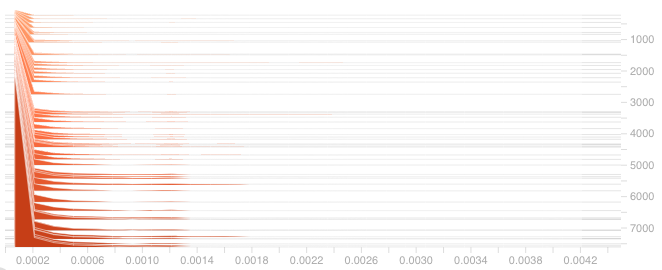

### Histogram plot for cosine distance between ground truth and prediction

From the below histogram, we observe that the predictions are concentrated around the low cosine distance space.

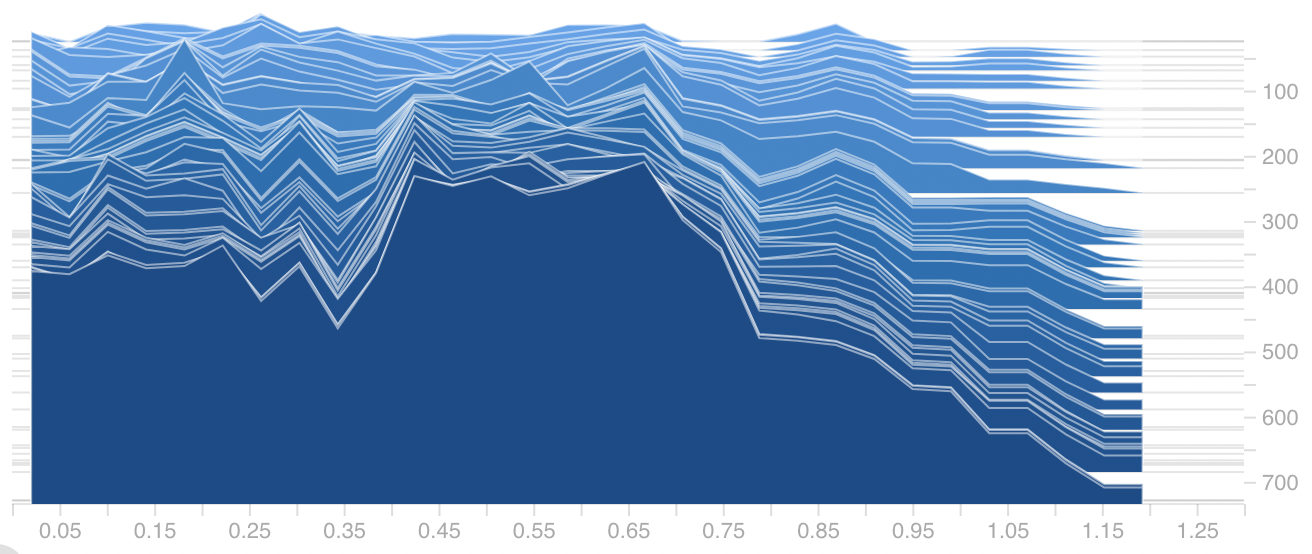

### Histogram plot for absolute log price ratio between prediction and selected items

We see that the price range of the predicted item is close to the price of the actually selected item

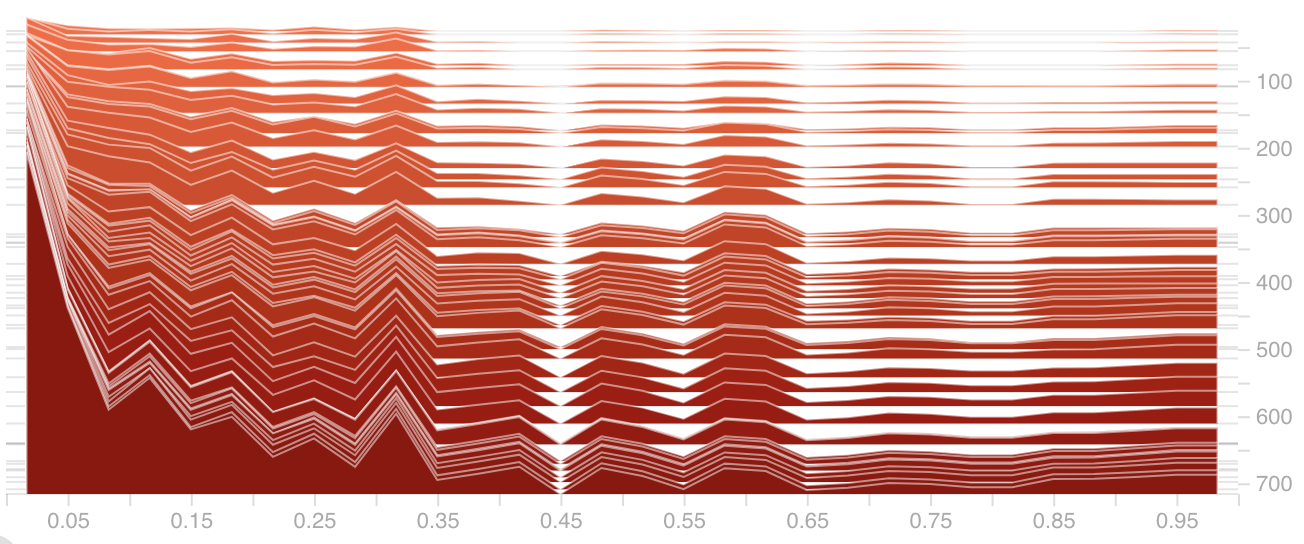